In [ ]:
import pandas as pd
import numpy as np

from madrigal.utils import BASE_DIR

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# load our metadata
drug_metadata = pd.read_pickle(BASE_DIR + "processed_data/views_features_new/combined_metadata_ddi.pkl")
drug_names = drug_metadata[['node_name', 'cmap_name']].apply(
    lambda row: (
        set([row[0].lower()] + list(name.lower() for name in row[1])) if row[1] == row[1] and row[1] is not None else set([row[0].lower()])
    ) if row[0] == row[0] and row[0] is not None else set(name.lower() for name in row[1]),
    axis=1
)
ddi_classes = pd.read_pickle(BASE_DIR + "processed_data/polypharmacy_new/DrugBank/drugbank_ddi_directed_final_label_map.pkl")
normalized_rank_drugbank = np.load(BASE_DIR + "model_output/DrugBank/split_by_pairs/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean_renormalized.npy", mmap_mode="r")

['str', 'kg', 'cv']


https://www.cancer.gov/research/infrastructure/clinical-trials/nci-supported/combomatch

```
EAY191-S3	Activating AKT mutation	Ipatasertib and paclitaxel	Solid tumors
EAY191-N2	NF1 nonsense or frameshift mutations or NF1 gene deletion	Binimetinib and fulvestrant	Hormone receptor-positive, HER2-negative metastatic breast cancer
EAY191-N4	RAS pathway mutation	Selumetinib and olaparib	Ovarian or endometrial cancer
EAY191-A6	MAPK pathway mutations	Binimetinib and chemotherapy  	Previously treated advanced biliary cancer
EAY191-A3	RAS pathway mutation	Palbociclib and binimetinib	Ovarian, pancreatic, and other solid tumors
EAY191-E5	KRAS G12C mutation	Sotorasib and panitumumab	Advanced solid tumors
EAY101-N5	HER2 amplification	Neratinib and palbociclib	Solid tumors
```

In [ ]:
organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')
all_labels = list(range(len(ddi_classes)))

to_delete = [
    10, 
    38, 
    65, 
    72,
    83,
    99, 
    147
]
to_delete_classes = [
    "adverse effects, decrease", 
    "cardiotoxicity, decrease",
    "hypertension, decrease",
    "hypoglycemia, decrease",
    "hypotension, decrease",
    "nephrotoxicity, decrease",
    "therapeutic efficacy, increase",
]
valid_ddi_class_indices = np.array([elem for elem in all_labels if elem not in to_delete])

custom_palette = {
    "others/general": "grey", 
    "blood": "orange",  # lightpink
    "heart": "red",  # marron
    "kidney": "purple",  # darkmagenta
    "gastrointestinal": "green",  # mediumseagreen
    "liver": "blue",  # cornflowerblue, steelblue
    "endocrine": "darkkhaki",
}

In [ ]:
combomatch_combos = [
    ["ipatasertib", "paclitaxel"], 
    ["binimetinib", "fulvestrant"], 
    ["selumetinib", "olaparib"], 
    ["binimetinib", "fluorouracil"], 
    ["binimetinib", "leucovorin"], 
    ["binimetinib", "oxaliplatin"], 
    ["palbociclib", "binimetinib"], 
    ["AMG-510", "panitumumab"], 
    ["neratinib", "palbociclib"], 
]

In [4]:
all_combomatch_drugs = list(set(sum(combomatch_combos, start=[])))

matched_indices = []
for drug_name in all_combomatch_drugs:
    matched_indices.append(drug_names.index.values[drug_names.apply(
        lambda lst: (drug_name.lower() in lst)
    )])
print([t for t, i in zip(all_combomatch_drugs, matched_indices) if len(i) == 0])

combomatch_drug_name_to_ind = {drug:ind for drug, ind in zip(all_combomatch_drugs, matched_indices) if len(ind) > 0}
combomatch_drug_name_to_ind

['panitumumab']


{'palbociclib': array([2066]),
 'olaparib': array([2067]),
 'fluorouracil': array([373]),
 'leucovorin': array([441]),
 'oxaliplatin': array([361]),
 'paclitaxel': array([815]),
 'ipatasertib': array([9338]),
 'fulvestrant': array([  628, 15320]),
 'binimetinib': array([2286]),
 'selumetinib': array([2234]),
 'AMG-510': array([3480]),
 'neratinib': array([2264])}

In [5]:
from collections import defaultdict

combomatch_drug_name_to_ind = {k:v[0] for k, v in combomatch_drug_name_to_ind.items()}

# maps each of the adverse ddi classes of interest to a SPECIFIC organ
specific_organs_mapping = defaultdict(list)
for i, organs in enumerate(organs_csv.iloc[valid_ddi_class_indices]["organ"].str.split(", ").values):
    for organ in organs:
        specific_organs_mapping[organ].append(i)
        
combomatch_drugs_for_stripplot = []
ddi_scores_for_stripplot = []
ddi_classes_for_stripplot = []
ddi_organs_for_stripplot = []
assert max(sum(specific_organs_mapping.values(), start=[])) == 150

for drug_1, drug_2 in combomatch_combos:
    if drug_1 == "panitumumab" or drug_2 == "panitumumab": continue
    drug_1_index = combomatch_drug_name_to_ind[drug_1]
    drug_2_index = combomatch_drug_name_to_ind[drug_2]
    ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]

    # specific_organs_mapping
    for organ, organ_ddi_index_lst in specific_organs_mapping.items():
        if organ in {"immune", "lung", "urinary"}: organ = "others/general"
        ddi_scores_for_stripplot.extend(ddi_filtered[organ_ddi_index_lst])
        ddi_classes_for_stripplot.extend(ddi_classes[valid_ddi_class_indices][organ_ddi_index_lst])
        ddi_organs_for_stripplot.extend([organ] * len(organ_ddi_index_lst))
        combomatch_drugs_for_stripplot.extend([f"{drug_1}; {drug_2}"] * len(organ_ddi_index_lst))

In [6]:
combomatch_df_filtered = pd.DataFrame.from_dict({
    "combomatch_drug_pair": combomatch_drugs_for_stripplot,
    "ddi_class": ddi_classes_for_stripplot,
    "value": ddi_scores_for_stripplot,
    "organ": ddi_organs_for_stripplot,
})
combomatch_df_filtered

,combomatch_drug_pair,ddi_class,value,organ
0,ipatasertib; paclitaxel,"CNS depression, hypotonia, increase",0.898115,others/general
1,ipatasertib; paclitaxel,"CNS depression, increase",0.964913,others/general
2,ipatasertib; paclitaxel,"absorption, decrease",0.904838,others/general
3,ipatasertib; paclitaxel,"absorption, decrease | serum level, decrease |...",0.923159,others/general
4,ipatasertib; paclitaxel,"absorption, increase | serum level, increase |...",0.807489,others/general
...,...,...,...,...
1435,neratinib; palbociclib,"liver enzyme elevations, increase",0.896110,liver
1436,neratinib; palbociclib,"metabolism, decrease",0.998810,liver
1437,neratinib; palbociclib,"metabolism, increase",0.998392,liver
1438,neratinib; palbociclib,"urinary retention, increase",0.751923,others/general


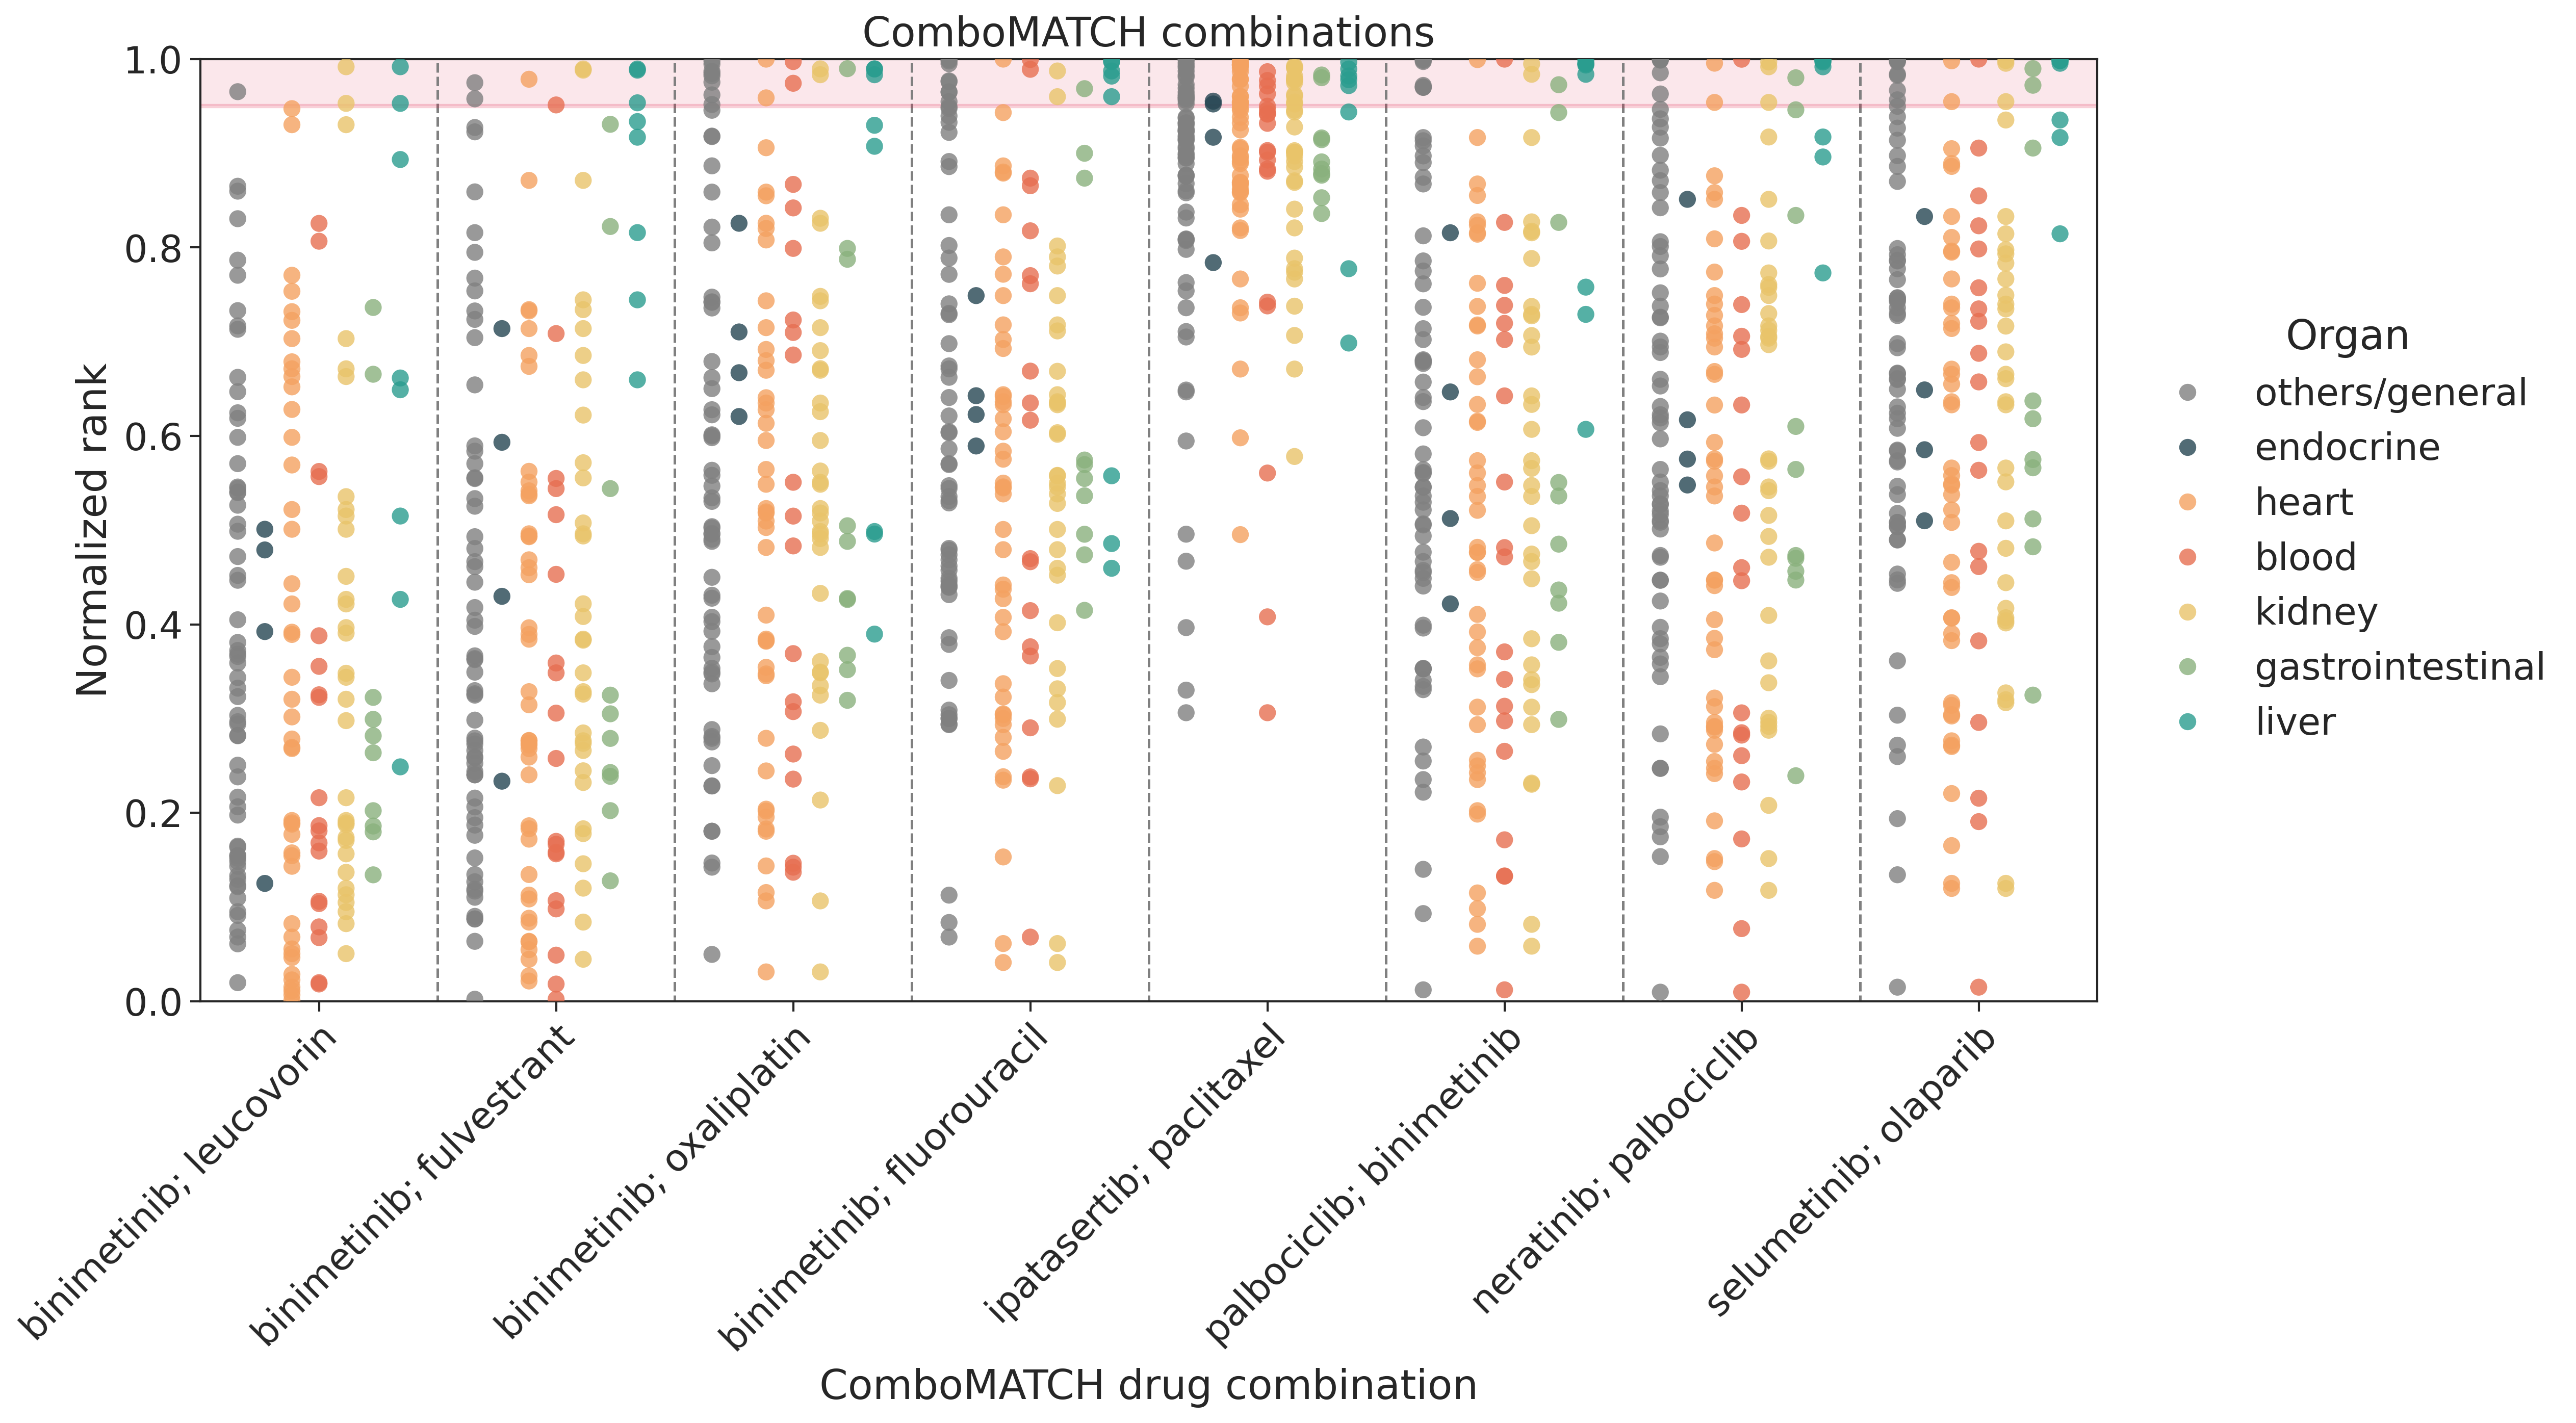

In [ ]:
plot_title = "ComboMATCH combinations"
sample_name_col_name = "combomatch_drug_pair"
custom_palette = {
    "others/general": "grey", 
    "blood": "#e76f51",  # lightpink
    "heart": "#f4a261",  # marron
    "kidney": "#e9c46a",  # darkmagenta
    "gastrointestinal": "#8ab17d",  # mediumseagreen
    "liver": "#2a9d8f",  # cornflowerblue, steelblue
    "endocrine": "#264653",
}

combomatch_df_filtered["combomatch_drug_pair"] = combomatch_df_filtered["combomatch_drug_pair"].str.replace("AMG-510", "sotarasib")
plot_data = combomatch_df_filtered.copy()

# Initialize the figure
plt.figure(figsize=(16, 8), dpi=300)
plt.rcParams["font.family"] = "Arial"
sns.set(style="ticks", context="paper", font_scale=2)

# Show each observation with a scatterplot
order = plot_data.groupby(sample_name_col_name).agg(list)["value"].apply(
    lambda x: np.mean(np.partition(x, len(x)-10)[-10:])
).sort_values().index.values
sns.stripplot(
    data=plot_data, y="value", x=sample_name_col_name, hue="organ", 
    palette=custom_palette, dodge=1.0, jitter=False, alpha=.8, order=order, s=8
)

# Put dashed horizontal lines to separate the drug combinations
x = 0.5
while x < 7.5:
    if x != 10.5:
        plt.axvline(x=x, ymin=-0.5, ymax=3.5, ls="--", color="grey")
    else:
        plt.axvline(x=x, ymin=-0.5, ymax=3.5, ls="-", lw=4, color="black")
    x += 1

threshold_to_count_ddi = 0.95
plt.ylim([0, 1])
plt.xlim([-0.5, 7.5])
plt.axhline(y=threshold_to_count_ddi, c="crimson", lw=2, alpha=0.2)
plt.axhspan(threshold_to_count_ddi, 1.0, color="crimson", alpha=0.1, lw=0)
plt.ylabel("Normalized rank")
plt.xlabel("ComboMATCH drug combination")
plt.title(plot_title)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', frameon=False, title="Organ")
# sns.despine(top=True, right=False)

plt.show()